In [13]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister,ClassicalRegister
from qiskit.quantum_info import Statevector, Operator, partial_trace
from qiskit.circuit import Measure
import itertools
import matplotlib.pyplot as plt
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import Sampler
from qiskit.primitives import SamplerResult
from qiskit.providers.basic_provider import BasicProvider
from qiskit import transpile
from qiskit_aer import Aer
from numpy import random
from collections import Counter
from qiskit_aer.primitives import SamplerV2
from qiskit.visualization import plot_histogram, array_to_latex
from latticecode import *
from KitaevToricCode import *
from scipy.interpolate import CubicSpline
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, pauli_error


from scipy.optimize import curve_fit
from scipy.special import erfc




In [ ]:

p_error = 0.04
print(p_error)

0.04


In [5]:
x0 = 0
x1 = 0
k0 = 3
k1 = 3

LatticeCircuit = KitaevToricModel(x0, x1,k0,k1, p_error)


job = AerSimulator().run(LatticeCircuit, shots=1, memory=True)

result = job.result()
memory = result.get_memory(LatticeCircuit)

memory_result = memory[0]

print(memory_result)
if memory_result[0:2] == str(x0) + str(x1):
    print( 'No logical error has been observed' )


00 000000011
No logical error has been observed


In [ ]:


def execute_model(x_0,x_1, k0,k1 , p_error, num_shots, success=True):
    success_rate = 0
    for i in range(num_shots):
        LatticeCircuit = KitaevToricModel(x_0, x_1, k0,k1, p_error, error=True)
        
        # transpiled = transpile(LatticeCircuit)
        # job = AerSimulator().run(transpiled, shots=1, memory=True)
        job = AerSimulator().run(LatticeCircuit, shots=1, memory=True)
        
        result = job.result()
        memory = result.get_memory(LatticeCircuit)

        memory_result = memory[0]
        
        if memory_result[0:2] == str(x_0) + str(x_1):
            success_rate += 1     
            
    if success == True:      
        return  success_rate/num_shots
    
    if success == False:
        return 1 - (success_rate/num_shots) 

        


Here, we see that the success rate of decoding to the correct logical state goes down as the rate of physical error goes up. Recall that if enough physical errors occur, then the syndrome recovery procedure may accumulate enough bit/phase flips as to cause a logical error.


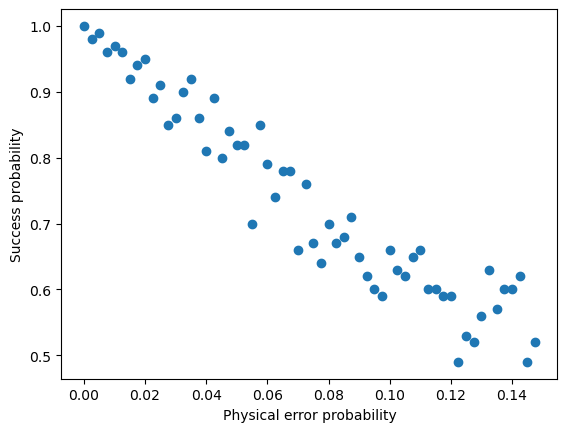

In [ ]:
x_0 = random.randint(0,1)
x_1 = random.randint(0,1)
error_rates = np.arange(0.00, 0.15, 0.0025)


success_rates_3x3 =  [execute_model(x_0,x_1,3,3,p,100) for p in error_rates]

plt.figure()
plt.scatter(error_rates, success_rates_3x3, label='k = 3' )


plt.ylabel("Success probability")
plt.xlabel("Physical error probability")
plt.show()

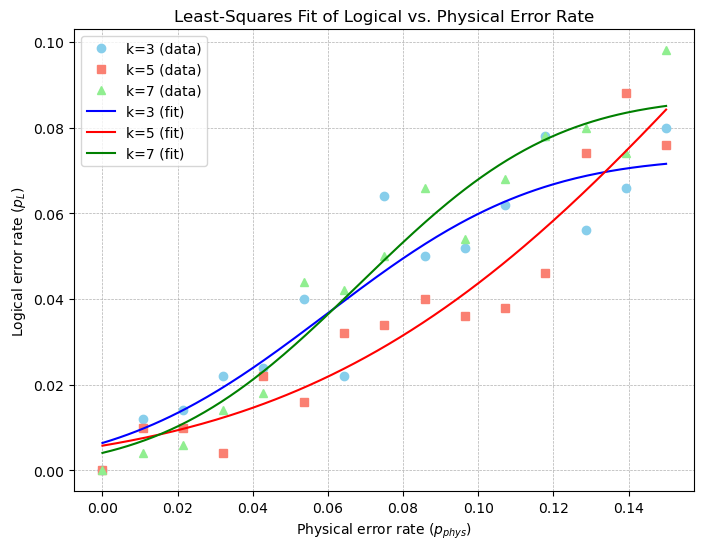

In [ ]:

x_0 , x_1 = 0,0
logical_error_rates_7x7 = [execute_model(x_0, x_1, 7, 7, p, 500, success=False) for p in error_rates]
logical_error_rates_5x5 = [execute_model(x_0, x_1, 5, 5, p, 500, success=False) for p in error_rates]
logical_error_rates_3x3 = [execute_model(x_0, x_1, 3, 3, p, 500, success=False) for p in error_rates]

# --- NEW: Define a model function for the fit ---
# This is a scaled error function, a good model for threshold phenomena.
def threshold_fit_function(p, A, p_th, sigma):
    """
    p: physical error rate (x-axis)
    A: amplitude/scaling factor
    p_th: threshold location
    sigma: width/steepness of the transition
    """
    return A * 0.5 * erfc((p_th - p) / sigma)


error_rates = np.linspace(0, 0.15, 15)

# --- NEW: Perform the least-squares fit for each dataset ---
# The 'p0' argument provides an initial guess for the parameters [A, p_th, sigma]
params_3, _ = curve_fit(threshold_fit_function, error_rates, logical_error_rates_3x3, p0=[1.0, 0.1, 0.05])
params_5, _ = curve_fit(threshold_fit_function, error_rates, logical_error_rates_5x5, p0=[1.0, 0.1, 0.05])
params_7, _ = curve_fit(threshold_fit_function, error_rates, logical_error_rates_7x7, p0=[1.0, 0.1, 0.05])

# --- Generate smooth curves using the fitted parameters ---
x_fit = np.linspace(0, 0.15, 200)
y_fit_3 = threshold_fit_function(x_fit, *params_3)
y_fit_5 = threshold_fit_function(x_fit, *params_5)
y_fit_7 = threshold_fit_function(x_fit, *params_7)

# --- Plot both the original data (as points) and the fits (as lines) ---
plt.figure(figsize=(8, 6))

# Plot the raw data points
plt.plot(error_rates, logical_error_rates_3x3, 'o', color='skyblue', label='k=3 (data)')
plt.plot(error_rates, logical_error_rates_5x5, 's', color='salmon', label='k=5 (data)')
plt.plot(error_rates, logical_error_rates_7x7, '^', color='lightgreen', label='k=7 (data)')

# Plot the fitted curves
plt.plot(x_fit, y_fit_3, color='blue', label='k=3 (fit)')
plt.plot(x_fit, y_fit_5, color='red', label='k=5 (fit)')
plt.plot(x_fit, y_fit_7, color='green', label='k=7 (fit)')

plt.title('Least-Squares Fit of Logical vs. Physical Error Rate')
plt.xlabel('Physical error rate ($p_{phys}$)')
plt.ylabel('Logical error rate ($p_L$)')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()